TODO:
explain
Import libraries
Calculate K and D from lensCalibration
Calculate pixel size to height ratio from pixelCalibration
Calculate pixel size for image
    Test images
    Import video, alt file, and frame
Output tiff

In [23]:
#Import Libraries

import cv2
assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'
import numpy as np
import os
import glob
import PIL.Image
from matplotlib import pyplot as plt
import math
import csv

In [59]:
# Lens Correction: Calc K and D from images

def measureLensDistortion(image_directory):
    CHECKERBOARD = (6,9)
    subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
    objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
    objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

    _img_shape = None
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob(image_directory)

    for fname in images:
        print ("processing:", fname)
        img = cv2.imread(fname)
        if _img_shape == None:
            _img_shape = img.shape[:2]
        else:
            assert _img_shape == img.shape[:2], "All images must share the same size."

        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
            imgpoints.append(corners)

    numOK = len(objpoints)
    K = np.zeros((3, 3))
    D = np.zeros((4, 1))
    rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(numOK)]
    tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(numOK)]
    rms, _, _, _, _ = cv2.fisheye.calibrate(objpoints,imgpoints,gray.shape[::-1],K,D,rvecs,tvecs,calibration_flags,(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))
    DIM = _img_shape[::-1]

    print("Found " + str(numOK) + " valid images for calibration")
    print("Image dimensions: ", DIM)
    print("K: ",K)
    print("D: ",D)
    
    return K,D,DIM

K,D,DIM = measureLensDistortion('lensCalibration/*.png') #save!

processing: lensCalibration/vlcsnap-2019-03-29-11h22m18s976.png
processing: lensCalibration/vlcsnap-2019-03-29-11h22m29s950.png
processing: lensCalibration/vlcsnap-2019-03-29-11h22m41s842.png
processing: lensCalibration/vlcsnap-2019-03-29-11h22m51s335.png
processing: lensCalibration/vlcsnap-2019-03-29-11h23m05s854.png
processing: lensCalibration/vlcsnap-2019-03-29-11h23m14s905.png
processing: lensCalibration/vlcsnap-2019-03-29-11h24m07s159.png
processing: lensCalibration/vlcsnap-2019-03-29-11h24m19s930.png
processing: lensCalibration/vlcsnap-2019-03-29-11h24m29s221.png
Found 8 valid images for calibration
Image dimensions:  (3840, 2160)
K:  [[2.16970525e+03 0.00000000e+00 1.82509199e+03]
 [0.00000000e+00 2.17037859e+03 1.04777248e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
D:  [[ 0.22354232]
 [ 0.04720017]
 [-0.02340375]
 [-0.05359537]]


In [62]:
def correctLensDistortion(img, k,d,dim):
    #img = cv2.imread(filename)
    h,w = img.shape[:2]
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(k, d, np.eye(3), k, dim, cv2.CV_16SC2)
    return cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)



def heightPixelRatio(cv_image, height_cm, diagonal_cm):
    CHECKERBOARD = (6,9) # dimension of corners (not squares) of the checkerboard
    gray = cv2.cvtColor(cv_image,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)

    # Find the pixel distance between the farthest corners of the checkerboard
    p1 = 0
    p2 = 0
    longdist = 0
    for i in corners:
        for j in corners:
            dist = math.hypot(j[0][0] - i[0][0], j[0][1] - i[0][1])
            if dist > longdist:
                p1 = tuple(i[0])
                p2 = tuple(j[0])
                longdist = dist
    
    pixelSize = diagonal_cm/longdist #pixel size in cm

    # ratio to go from height picture taken to pixel size (unitless) constant for camera (I think)
    return pixelSize/height_cm

def tagAndSaveTIF(cv_image, height_cm, height_pixel_ratio, export_location):
    pixelsPerCM = 1/(height_pixel_ratio*height_cm)
    
    im_pil = PIL.Image.fromarray(cv_image)
    im_pil.save(export_location,
                x_resolution = pixelsPerCM, # pixels per cm
                y_resolution = pixelsPerCM, # pixels per cm
                resolution_unit = 3 ) # unit = cm

    


In [ ]:
calibration_image = 'pixelCalibration/805mm.png'
camera_altitude = 80.5 #cm
checkerboard_diagonal = 22.5 #cm
output_image = 'output/calibrationTest.tif'

corrected_img = correctLensDistortion(calibration_image,K,D,DIM)
height2pixel = heightPixelRatio(corrected_img, camera_altitude, checkerboard_diagonal) #save!
tagAndSaveTIF(corrected_img,camera_altitude,height2pixel,output_image)

In [13]:
test_image = 'testImages/20m.png'
camera_altitude = 2000 #cm
output_image = 'output/20mTest.tif'

plt.imshow(gray, cmap='gray')


corrected_img = correctLensDistortion(cv2.imread(test_image),K,D,DIM)
tagAndSaveTIF(cv2.imread(test_image),camera_altitude,height2pixel,output_image)

In [52]:
def getAltFromLog(filename, time):

    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        filedict = {float(rows[0]):float(rows[1]) for rows in reader}
        
    return filedict.get(time, filedict[min(filedict.keys(), key=lambda k: abs(k-time))])


time:  1540017881
alt:  2550  cm


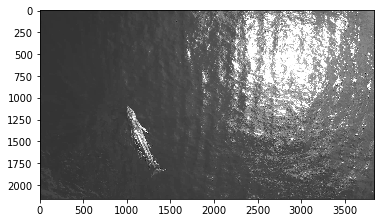

In [79]:
video_start = 1540017697 #unix time
cap = cv2.VideoCapture('data/1540017697.MP4')
seconds_in = 184
output_image = 'output/whale.tif'

print ("time: ",video_start+seconds_in)


camera_altitude = 2550 #100*getAltFromLog('data/000085_altLog.csv', video_start+seconds_in)

print("alt: ",camera_altitude," cm")

fps = cap.get(cv2.CAP_PROP_FPS)

amount_of_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

cap.set(cv2.CAP_PROP_POS_FRAMES, seconds_in*fps)
ret, frame = cap.read()
cap.release()

frame = cv2.resize(frame, (3840, 2160), cv2.INTER_CUBIC)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#cv2.imshow('frame',gray)
plt.imshow(gray, cmap='gray')

corrected_frame = correctLensDistortion(frame,K,D,DIM)
tagAndSaveTIF(frame,camera_altitude,height2pixel,'output/whale.tif')
tagAndSaveTIF(corrected_frame,camera_altitude,height2pixel,'output/whaleC.tif')



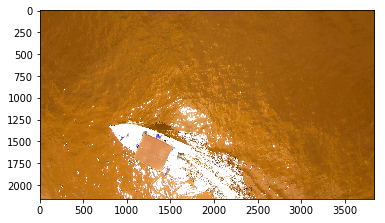

In [76]:
scaled_img = cv2.resize(frame, (3840, 2160), cv2.INTER_CUBIC)
plt.imshow(scaled_img, cmap='gray')

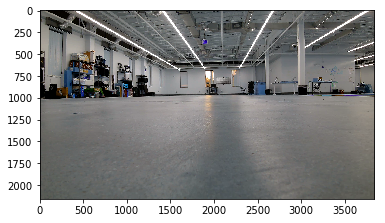

In [69]:
plt.imshow(cv2.imread('testImages/20m.png'), cmap='gray')

In [ ]:
def getFramesFromVideo(video,seconds)